In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.ticker as mticker
import warnings
sns.set()

import os
import yaml
import pandas as pd
import scipy
import numpy
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import sqrt
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import sem, t
from scipy.stats import linregress

warnings.simplefilter('ignore')

In [2]:
def parse_diff_pressure(df):
    dispenses_full = []
    for i in range(len(df)):
        dict_string = df['fc_sensor_data'].iloc[i]
        dispenses_full.append(ast.literal_eval(dict_string))

    curves = []
    baselines = []
    peaks = []
    AUCs = []
    gauge_pressures = []
    abs_pressures = []
    lengths = []
    
    for dispense in dispenses_full:
        length = len(dispense)
        single_dispense = []
        try:
            gauge_pressure = dispense[1][1]['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['abs_pressure_bar']
        except KeyError:
            gauge_pressure = dispense[1][1]['state']['gauge_pressure_psi']
            abs_pressure = dispense[1][1]['state']['abs_pressure_bar']
        gauge_pressures.append(gauge_pressure)
        abs_pressures.append(abs_pressure)
        for point in dispense:
            try:
                single_dispense.append(-1 * point[1]['state']['diff_pressure'])
            except KeyError:
                try:
                    single_dispense.append(-1 * point[1]['diff_pressure'])
                except KeyError:
                    print("Key Error: {}".format(point))
                    pass
        try:
            baseline=single_dispense[0]
            baselines.append(baseline)
            for i in range(len(single_dispense)):
                single_dispense[i] = single_dispense[i] - baseline
            peaks.append(max(single_dispense))
            AUCs.append(np.trapz(single_dispense))
            curves.append(single_dispense)
            lengths.append(length)
        
        except IndexError:
            print("IndexError: {}".format(single_dispense))
            curves.append([0])
            baselines.append(0)
            peaks.append(0)
            AUCs.append(0)
            lengths.append(0)

    dict_to_df = {'pressure_curves': curves,
                  'length': lengths,
                 'baseline': baselines,
                 'peak': peaks,
                 'AUC': AUCs,
                 'gauge_pressure': gauge_pressures,
                 'abs_pressure': abs_pressures}
    curve_df = pd.DataFrame(dict_to_df)
    return curve_df

def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [3]:
means = []
stds = []
df_all = []
for file in os.listdir('curve_data/'):
    if file.endswith('csv'):
        # Parse data frame and extract differential pressure curve, re-add to dataframe
        filename = 'curve_data/' + file
        print(filename)
        df = pd.read_csv(filename)
        df = df.loc[(df['device_task_view_id'] != 'calibrate')
           & (df['device_task_view_id'] != 'prep_reagents')
           & (df['device_task_top_level'] != 'Calibrate Fluidics')
           & (df['device_task_top_level'] != 'Fluidics Preflight')].copy()
        print(df.shape[0])
        df = df.loc[df['weight_mg'].between(0.85 * df['volume_ul'], 1.15 * df['volume_ul'])].copy()
        print(df.shape[0])
        curve_df = parse_diff_pressure(df)
        df.reset_index(inplace=True, drop=True)
        dfs = [df, curve_df]
        df = pd.concat(dfs, axis=1).copy()
        df_all.append(df)
        
df = pd.concat(df_all)
df = df.loc[df['peak'] < 1000].copy()
# Get mean and standard deviation
mean_array, std_array = tolerant_mean(df['pressure_curves'])

mean_array

curve_data/20201208_sequoia_dispense_logs.csv
1205
251
curve_data/Glacier_reseat.csv
2174
1717
curve_data/Glacier_swapped.csv
2205
1725
curve_data/olympic_all_reagents_same.csv
2180
1669
curve_data/Olympic_reseat.csv
2173
1678
curve_data/Olympic_same_with_reagent.csv
2164
1669
curve_data/Olympic_swapped.csv
2100
1539
curve_data/Olympic_swap_no_filter.csv
2101
1692
curve_data/rc_reagent_dispenses.csv
2339
754
curve_data/rc_reagent_dispenses_1.csv
2380
846


masked_array(data=[0.0, 51.16468415219801, 179.52657369016208,
                   246.9461585458989, 282.129880051952,
                   299.30344338507604, 310.76851598797487,
                   321.3651223321187, 327.2629982215713,
                   330.0335781741868, 331.0074034902168,
                   332.6423154971697, 333.25425578350064,
                   334.0118187787262, 335.07536422390183,
                   336.55526170798896, 337.79705979882834,
                   339.00232172470976, 339.8207056741511,
                   339.3297777777778, 339.63290569435065,
                   336.0856667590796, 335.9289892752681,
                   336.8379440170241, 337.8274153592073, 341.257216940363,
                   371.57527675276754, 260.8708609271523,
                   244.3905683192261, 286.85714285714283, 325.5, 316.0,
                   315.6666666666667, 288.0, 216.0, 228.0, 235.5, 247.5,
                   268.5, 271.5, 275.0, 248.5, 237.5, 226.5, 223.0, 221.5,
       

In [10]:
dict_for_df = {'mean_array': mean_array,
               'stdev_array': std_array}
temp_df = pd.DataFrame(dict_for_df).head(30)
temp_df.to_csv('curve_data/average_pressure_curve.csv')

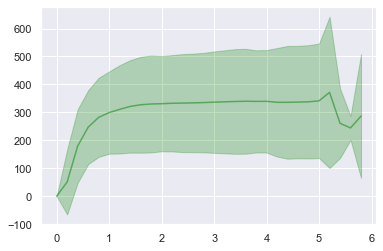

In [11]:
new_df = pd.read_csv('curve_data/average_pressure_curve.csv')

fig, ax = plt.subplots()
time = [a/5 for a in range(new_df.shape[0])]
ax.plot(time, new_df['mean_array'], color='green', alpha=0.5)
ax.fill_between(time, 
                new_df['mean_array'] + 2*new_df['stdev_array'], 
                new_df['mean_array'] - 2*new_df['stdev_array'], 
                color='green', alpha=0.25)